In [16]:
import pandas as pd
from pandas import DataFrame
import requests
import os
import os.path
import datetime as dt
import json
import numpy as np
from datetime import timedelta, datetime
from dateutil import parser
import math
%matplotlib inline
from matplotlib import pyplot as plt

from dotenv import load_dotenv
load_dotenv()

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load environment variables 
binance_api_key = os.getenv("BINANCE_API_KEY")
binance_secret_key= os.getenv("BINANCE_SECRET_KEY")



In [3]:
type(binance_api_key)

str

In [4]:
## Set up client 
from binance.client import Client
binance_client = Client(api_key=binance_api_key, api_secret=binance_secret_key)

# Constants
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750

# Create collecting new data function
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2015', '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

# Create function to retreive tickers and timestamps
def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2015', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

In [5]:
symbols = ['LINKBTC', 'VETBTC', 'WTCBTC']

In [6]:
# Get chainlink data
link_data=get_all_binance('LINKBTC', '1h')
link_data.head()

All caught up..!


,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2017-09-28 08:00:00,0.00003000,0.00003000,0.00003000,0.00003000,100.00000000,1506589199999,0.00300000,1,100.00000000,0.00300000,30001.69600000
2017-09-28 09:00:00,0.00008600,0.00008900,0.00004620,0.00004620,853945.00000000,1506592799999,48.52663619,645,257197.00000000,13.72629174,6500707.40881102
2017-09-28 10:00:00,0.00004700,0.00006878,0.00004700,0.00006500,2161631.00000000,1506596399999,121.79431620,843,929032.00000000,52.10048144,8465292.69686671
2017-09-28 11:00:00,0.00006500,0.00008270,0.00006219,0.00006662,2060651.00000000,1506599999999,144.51245560,1268,649557.00000000,46.64358554,13052415.49262562
2017-09-28 12:00:00,0.00006662,0.00006664,0.00005209,0.00006002,1124998.00000000,1506603599999,68.62397421,689,321803.00000000,19.15174859,18460641.76811298


In [7]:
link_data=link_data.loc[:,['high', 'low', 'close']]

In [8]:
link_data=link_data.apply(pd.to_numeric)

In [9]:
link_data = link_data.loc['2020-06-11 01:00:00':'2020-07-11 01:00:00']

In [12]:
link_data['delta'] = link_data['close'].diff()
link_data = link_data.dropna()

In [13]:
# Make the positive gains (up) and negative gains (down) Series
up, down = link_data['delta'].copy(), link_data['delta'].copy()
up[up < 0] = 0
down[down > 0] = 0

window_length = 14

# Calculate the EWMA
roll_up1 = up.ewm(span=window_length).mean()
roll_down1 = down.abs().ewm(span=window_length).mean()

# Calculate the RSI based on EWMA
RS1 = roll_up1 / roll_down1
link_data['RSI1'] = 100.0 - (100.0 / (1.0 + RS1))

In [14]:
link_data.tail()

,high,low,close,delta,RSI1
timestamp,,,,,
2020-07-10 21:00:00,0.000667,0.000653,0.000658,-7.500000e-06,58.345594
2020-07-10 22:00:00,0.000666,0.000656,0.000662,4.780000e-06,62.795763
2020-07-10 23:00:00,0.000665,0.000659,0.000662,-5.600000e-07,61.901785
2020-07-11 00:00:00,0.000674,0.000662,0.000671,8.840000e-06,69.746601
2020-07-11 01:00:00,0.000675,0.000666,0.000667,-3.260000e-06,64.127871


Text(0.5, 1.0, 'RSI')

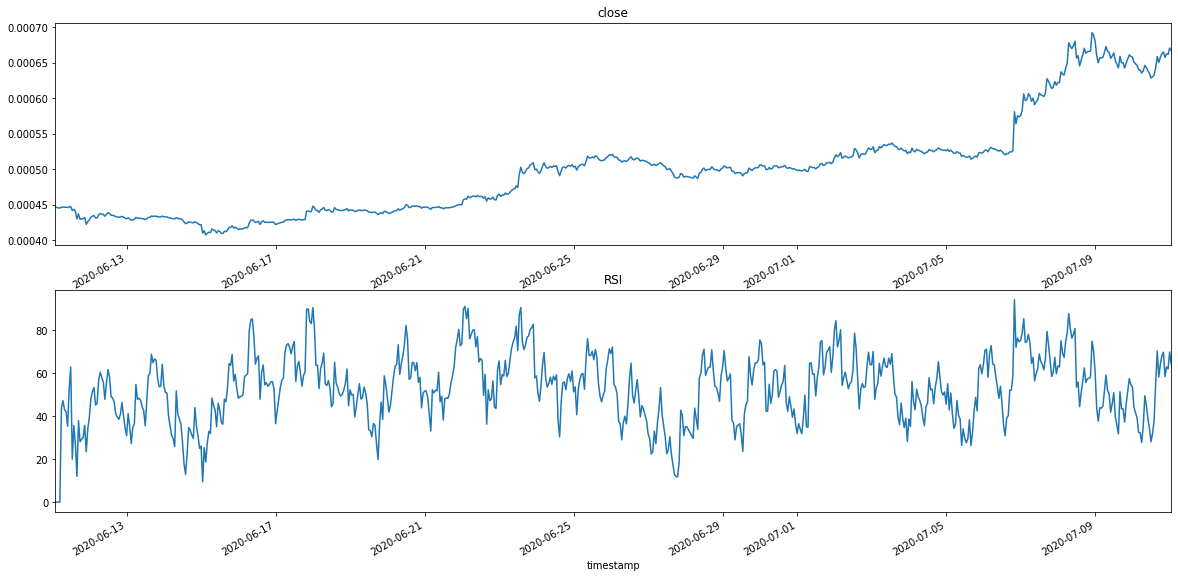

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,10))
link_data['close'].plot(ax=axes[0]); axes[0].set_title('close')
link_data['RSI1'].plot(ax=axes[1]); axes[1].set_title('RSI')

In [61]:
# # Construct a short/long trading signal
# link_df['short'] = np.where(link_df['RSI1'] > 70, 1.0, 0.0)
# link_df['long'] = np.where(link_df['RSI1'] < 30, -1.0, 0.0)
# link_df['rsi_signal'] = link_df['short'] + link_df['long']

In [40]:
#Create a column in the DataFrame showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
#A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
link_data['Sell Entry'] = link_data['RSI1'] > 70
#Create a column in the DataFrame showing "TRUE" if sell exit signal is given and "FALSE" otherwise. 
#A sell exit signal is given when the %K line crosses back up through the %D line 
link_data['Sell Exit'] = link_data['RSI1'] < 70
#create a placeholder column to populate with short positions (-1 for short and 0 for flat) using boolean values created above 
link_data['Short'] = np.nan 
link_data.loc[link_data['Sell Entry'],'Short'] = -1 
link_data.loc[link_data['Sell Exit'],'Short'] = 0 
#Set initial position on day 1 to flat 
link_data['Short'][0] = 0 
#Forward fill the position column to represent the holding of positions through time 
link_data['Short'] = link_data['Short'].fillna(method='pad') 
#Create a column in the DataFrame showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
#A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
link_data['Buy Entry'] = link_data['RSI1'] < 30
#Create a column in the DataFrame showing "TRUE" if buy exit signal is given and "FALSE" otherwise. 
#A buy exit signal is given when the %K line crosses back down through the %D line 
link_data['Buy Exit'] = link_data['RSI1'] > 30
#create a placeholder column to polulate with long positions (1 for long and 0 for flat) using boolean values created above 
link_data['Long'] = np.nan  
link_data.loc[link_data['Buy Entry'],'Long'] = 1  
link_data.loc[link_data['Buy Exit'],'Long'] = 0  
#Set initial position on day 1 to flat 
link_data['Long'][0] = 0  
#Forward fill the position column to represent the holding of positions through time 
link_data['Long'] = link_data['Long'].fillna(method='pad') 
#Add Long and Short positions together to get final strategy position (1 for long, -1 for short and 0 for flat) 
link_data['Position'] = link_data['Long'] + link_data['Short']


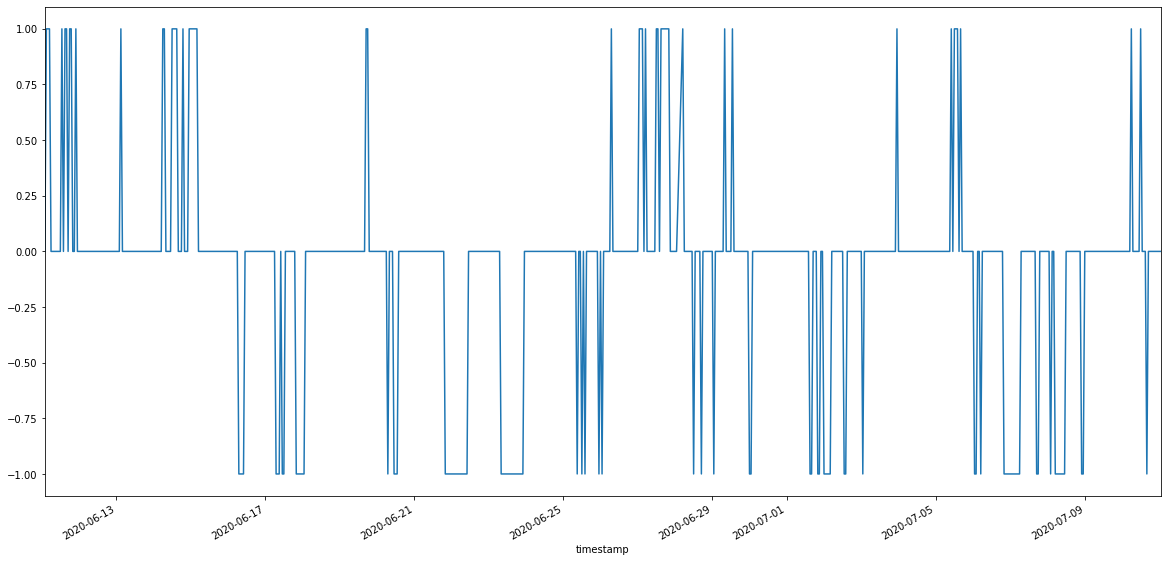

In [41]:
link_data['Position'].plot(figsize=(20,10))

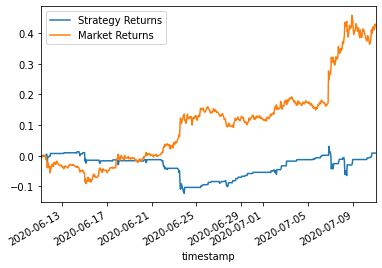

In [42]:
#Set up a column holding the daily Apple returns
link_data['Market Returns'] = link_data['close'].pct_change()
#Create column for Strategy Returns by multiplying the daily Apple returns by the position that was held at close
#of business the previous day
link_data['Strategy Returns'] = link_data['Market Returns'] * link_data['Position'].shift(1)
#Finally plot the strategy returns versus Apple returns
link_data[['Strategy Returns','Market Returns']].cumsum().plot()

In [44]:
link_data.tail()

,high,low,close,delta,RSI1,Sell Entry,Sell Exit,Short,Buy Entry,Buy Exit,Long,Position,Market Returns,Strategy Returns
timestamp,,,,,,,,,,,,,,
2020-07-10 21:00:00,0.000667,0.000653,0.000658,-7.500000e-06,58.345594,False,True,0.0,False,True,0.0,0.0,-0.011275,-0.0
2020-07-10 22:00:00,0.000666,0.000656,0.000662,4.780000e-06,62.795763,False,True,0.0,False,True,0.0,0.0,0.007268,0.0
2020-07-10 23:00:00,0.000665,0.000659,0.000662,-5.600000e-07,61.901785,False,True,0.0,False,True,0.0,0.0,-0.000845,-0.0
2020-07-11 00:00:00,0.000674,0.000662,0.000671,8.840000e-06,69.746601,False,True,0.0,False,True,0.0,0.0,0.013356,0.0
2020-07-11 01:00:00,0.000675,0.000666,0.000667,-3.260000e-06,64.127871,False,True,0.0,False,True,0.0,0.0,-0.004860,-0.0


In [73]:
# link_sosc_position = link_data.loc[:,'Position']


In [79]:
type(link_sosc_position)

pandas.core.series.Series

In [81]:
from pandas import Series, DataFrame 

In [83]:
link_sosc_position = Series.to_frame(link_sosc_position).reset_index()

In [89]:
link_sosc_position = link_sosc_position.rename(columns={0:'SOSC Position'})

In [90]:
link_sosc_position.head()

,timestamp,SOSC Position
0,2020-06-11 01:00:00,0.0
1,2020-06-11 02:00:00,0.0
2,2020-06-11 03:00:00,0.0
3,2020-06-11 04:00:00,0.0
4,2020-06-11 05:00:00,0.0


In [91]:
link_sosc_position.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 2 columns):
timestamp        718 non-null datetime64[ns]
SOSC Position    718 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.3 KB


In [94]:
link_sosc_position.to_csv('link_sosc_position.csv')